In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Is a population centered at zero?

Let's imagine observing a set $\{\hat x\}$ of values. We know *a priori* that the underlying population is a Gaussian with a width $\sigma$, and our individual-event likelihoods are also Gaussian with width $\sigma_\mathrm{obs}$.

We wish to **infer** the underlying mean $\mu$ of the population.
In particular, is $\mu=0$, or is $\mu \ne 0$?
How often will a Bayes factor between these two hypotheses lead us astray?

We will restrict ourselves to a *single* injected population, with

\begin{equation}
\mu = 0
\end{equation}

In [2]:
true_mean = 0.
true_sig = 0.5

Our likelihood on $\mu$ is

\begin{equation}
\begin{aligned}
p(\{\hat x\}|\mu) &= \prod_i \int dx \,p(\hat x_i | x)\, p(x|\mu) \\
&\propto \prod_i \int dx \exp\left( - \frac{(\hat x_i - x)^2}{2\sigma_\mathrm{obs}^2}\right)
    \exp\left( - \frac{(x - \mu)^2}{2\sigma^2}\right) \\
&\propto \prod_i \exp \left( - \frac{(\hat x_i - \mu)^2}{2(\sigma^2 + \sigma_\mathrm{obs}^2)}\right)
\end{aligned}
\end{equation}

or

\begin{equation}
\log p(\{\hat x\}|\mu) = \sum_i \left( - \frac{(\hat x_i - \mu)^2}{2(\sigma^2 + \sigma_\mathrm{obs}^2)}\right) + \mathrm{constants}
\end{equation}

Let's repeatedly draw catalogs of observed values $\{\hat x\}$, for each catalog computing a posterior on $\mu$:

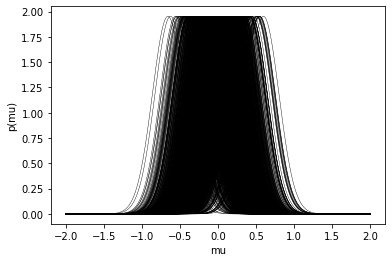

In [3]:
# This is the width of our individual-event likelihoods
sig_obs = 1

# Set up a grid of mu values over which to compute a likelihood,
# and an empty array of likelihoods to fill in as we loop across catalogs
mu_grid = np.linspace(-2,2,400)
nCatalogs = 1000
p_mu = np.zeros((nCatalogs,mu_grid.size))

# Loop across catalogs
for i in range(nCatalogs):

    # For each catalog, draw a set of "truths", followed by a set of max-likelihood values
    xs_true = np.random.normal(loc=true_mean,scale=true_sig,size=30)
    xs_maxLikelihood = xs_true + np.random.normal(loc=0,scale=sig_obs,size=30)

    # Loop across potential population means, computing the log likelihood for each
    log_p_mu = np.zeros_like(mu_grid)
    for ii,mu in enumerate(mu_grid):
        log_p_mu[ii] = np.sum(-(xs_maxLikelihood-mu)**2/(2.*(true_sig**2+sig_obs**2)))
    
    # Exponentiate, subtract off the max to prevent any overflow issues, and normalize
    log_p_mu -= np.max(log_p_mu)
    p_mu_catalog = np.exp(log_p_mu)
    p_mu_catalog /= np.trapz(p_mu_catalog,mu_grid)
    p_mu[i,:] = p_mu_catalog

# Plot our collection of posteriors
fig,ax = plt.subplots()
ax.plot(mu_grid,p_mu.T,color='black',lw=0.4)
ax.set_xlabel('mu')
ax.set_ylabel('p(mu)')
plt.show()

For every catalog, compute a Bayes factor between two hypotheses:

**A**: The population mean is non-zero

**B**: The population mean is zero

(Recall that Hypothesis B is correct)

In [4]:
# Loop across catalogs
bayes = np.zeros(nCatalogs)
for i in range(nCatalogs):
    
    # For each catalog, evaluate the posterior at mu = 0
    p_zero = np.interp(0,mu_grid,p_mu[i,:])
    
    # Compute the Bayes factor p(d|Hypothesis A)/p(d|Hypothesis B) via a Savage-Dickey ratio
    bayes[i] = 1./p_zero

Text(0, 0.5, 'CDF')

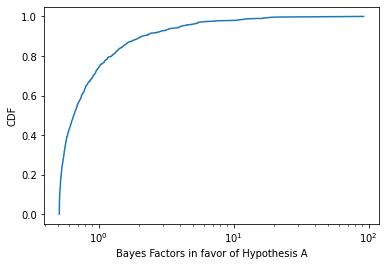

In [5]:
fig,ax = plt.subplots()
ax.plot(np.sort(bayes),np.cumsum(np.ones_like(bayes))/bayes.size)
ax.set_xscale('log')
ax.set_xlabel("Bayes Factors in favor of Hypothesis A")
ax.set_ylabel("CDF")

While Bayes factors are most commonly less than or equal to one (correctly indicating a preference for Hypothesis B), we **regularly see very large Bayes factors incorrectly in favor of Hypothesis A**!

We can alternatively look at the probability that Hypothesis A is correct:

\begin{equation}
p(A) = \frac{p(A)}{p(A) + p(B)} = \frac{1}{1 + \frac{1}{\mathcal{B}^A_B}}
\end{equation}

Text(0, 0.5, 'CDF')

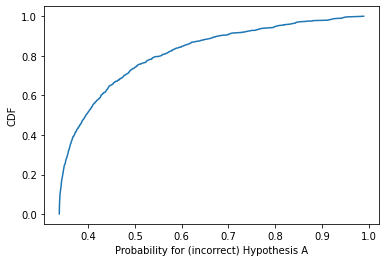

In [6]:
prob_A = 1./(1.+1./bayes)

fig,ax = plt.subplots()
ax.plot(np.sort(prob_A),np.cumsum(np.ones_like(prob_A))/prob_A.size)
ax.set_xlabel("Probability for (incorrect) Hypothesis A")
ax.set_ylabel("CDF")

Although Hypothesis A is incorrect, we have a tail to large probabilities, including those that indicate with near certainty that A is correct.